In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import sys

In [2]:

sys.path.append('../scr')

from utils_clean import filtrar_ub_mensual, partir_train_test
from utils_data import downloadTable
from utils_model import buscar_hiperparametros_arima_sarima
from utils_metrics import errorMetrics

# Importar datos de Big Query

In [3]:
queryPrices = """
SELECT * FROM `desarrollo-444913.globalPrices.prices`
"""
# Usar forceDownload=True para actualizar la tabla
df = downloadTable(queryPrices,"globalPricesTable",forceDownload=False)

Folder 'bigqueryDatabases' already exists.
Reading bigqueryDatabases\globalPricesTable.csv from local CSV.


# Preprocesamiento

In [4]:
dfUbMensual = filtrar_ub_mensual(df)

# Visualización

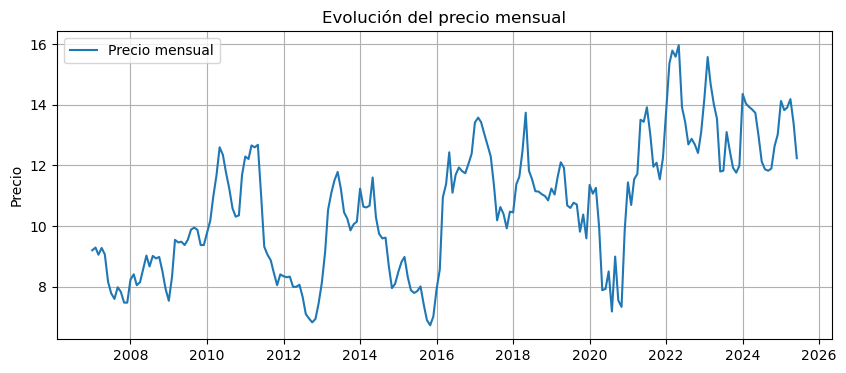

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(dfUbMensual, label="Precio mensual")
plt.title("Evolución del precio mensual")
plt.ylabel("Precio")
plt.grid(True)
plt.legend()
plt.show()

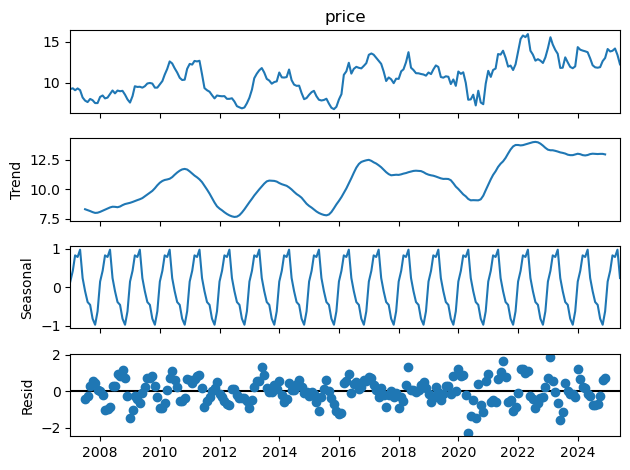

In [6]:
result = seasonal_decompose(dfUbMensual, model='additive', period=12)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

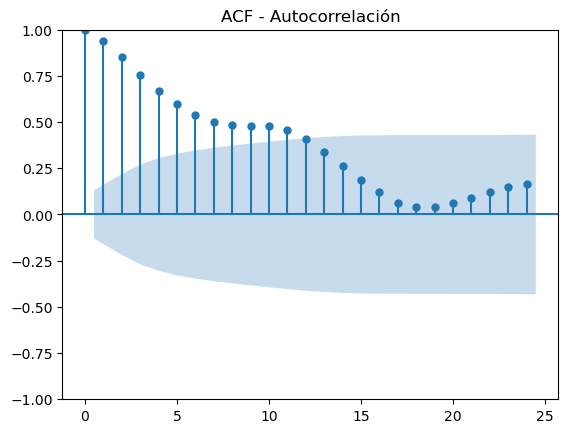

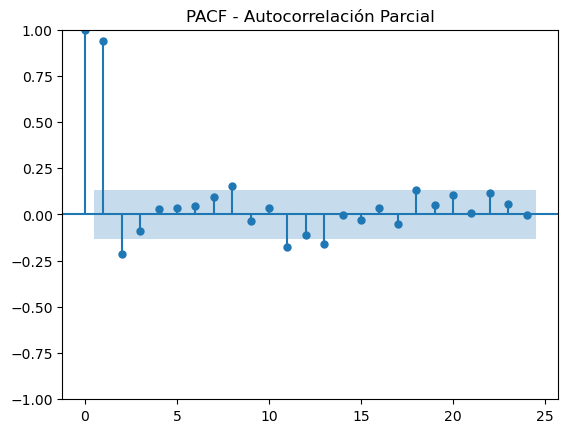

In [7]:

plot_acf(dfUbMensual, lags=24)
plt.title("ACF - Autocorrelación")
plt.show()

plot_pacf(dfUbMensual, lags=24)
plt.title("PACF - Autocorrelación Parcial")
plt.show()


In [8]:

resultado = adfuller(dfUbMensual)
valor_p = resultado[1]
print(f"p: {valor_p}")

# Interpretar el resultado
if valor_p < 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("La serie no es estacionaria (no se puede rechazar la hipótesis nula).")

# Como es estacionaria, no es necesario diferenciarla

p: 0.03102517498705364
La serie es estacionaria (se rechaza la hipótesis nula).


# Modelado

## Train-test split

In [9]:
# Vamos a usar hasta 2023 y testear en 2024
dfUbMensual = dfUbMensual.sort_index()
# Entrenamiento: todo hasta diciembre 2024
train = dfUbMensual.loc[:'2023-12-01']   # Ajusta el string según tu índice
# Test: enero, febrero, marzo 2025
test = dfUbMensual.loc['2024-01-01':'2024-12-01']


## Ajuste Para Seasonal Arima

In [10]:
modelo, order, seasonal_order, resumen = buscar_hiperparametros_arima_sarima(train, m=12, seasonal=True)
print(resumen)
print("Mejores (p, d, q):", order)
print("Mejores (P, D, Q, m):", seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=459.313, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=452.708, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=453.522, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=457.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=455.523, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=453.439, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=453.208, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=455.289, Time=0.07 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=454.659, Time=0.12 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=454.676, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=452.960, Time=0.10 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=456.632, Time=0.27 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AI

## Forecast horizonte de un año

In [27]:
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-01', freq='MS')


modelo = ARIMA(serie_rolling, order = order,seasonal_order = seasonal_order)
fitted = modelo.fit()
pred = fitted.forecast(steps=12)
print(errorMetrics(test.to_numpy(), pred.to_numpy()))


{'mse': 1.6111259141242262, 'mse_std': 1.4661073722805609, 'mae': 1.0512636741979604, 'mae_std': 0.7113161051431569, 'rmse': 1.2693013488231335, 'rmse_std': 0.7113161051431569, 'mape': 7.734048777477272, 'mape_std': 4.99706056495425}


year_month
2024-01-01    14.354526
Name: price, dtype: float64

## Ajuste Para Seasonal Arima with Kalman Filter adapt one step Prediction

In [31]:
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-01', freq='MS')
modelo = ARIMA(serie_rolling, order = order,seasonal_order = seasonal_order)
fitted = modelo.fit()
pred = []
for i in range(len(fechas_pred)):
    if i ==0:
        pred.append(fitted.forecast(steps=1)[0])
    else:
        fitted = fitted.extend(test[i-1:i])
        pred.append(fitted.forecast(steps=1)[0])

modelo = ARIMA(serie_rolling, order = order,seasonal_order = seasonal_order)
fitted = modelo.fit()
print(errorMetrics(test.to_numpy(), np.array(pred)))

{'mse': 0.5874151154858845, 'mse_std': 1.2693540619216388, 'mae': 0.5023374401262529, 'mae_std': 0.5788542232145222, 'rmse': 0.7664301112860092, 'rmse_std': 0.5788542232145222, 'mape': 3.772619876477728, 'mape_std': 4.070451228277196}


# Rolling predictions

In [12]:
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-01', freq='MS')

for fecha in fechas_pred:
    modelo = ARIMA(serie_rolling, order=order,seasonal_order=seasonal_order)
    fitted = modelo.fit()
    pred = fitted.forecast(steps=1)[0]
    predicciones.append(pred)
    
    # Rolling: Si hay valor real, lo uso; si no, uso lo predicho
    if fecha in df.index:  # Hay valor real disponible (enero a mayo 2025)
        valor_a_agregar = df.loc[fecha]
    else:  # De junio a diciembre, ya no hay real
        valor_a_agregar = pred
    
    # Concatenar el valor (como pd.Series, con índice fecha)
    serie_rolling = pd.concat([serie_rolling, pd.Series([valor_a_agregar], index=[fecha])])


# Crea una lista de reales solo para las fechas disponibles
reales_disponibles = [df[fecha] if fecha in df.index else np.nan for fecha in fechas_pred]
pred_df = pd.DataFrame({'real': reales_disponibles, 'predicho': predicciones}, index=fechas_pred)
print(pred_df)

            real   predicho
2024-01-01   NaN  12.183917
2024-02-01   NaN  12.400131
2024-03-01   NaN  12.260583
2024-04-01   NaN  12.154326
2024-05-01   NaN  12.078512
2024-06-01   NaN  11.803230
2024-07-01   NaN  11.807605
2024-08-01   NaN  12.009239
2024-09-01   NaN  11.910111
2024-10-01   NaN  11.822524
2024-11-01   NaN  11.797288
2024-12-01   NaN  11.833701


# Evaluación

In [13]:
# Añade año y cuartil (trimestre)
pred_df['año'] = pred_df.index.year
pred_df['cuartil'] = pred_df.index.quarter
pred_df['cuartil_str'] = pred_df['año'].astype(str) + '-Q' + pred_df['cuartil'].astype(str)

# Calcula métricas para cada cuartil con datos reales
for cuartil in pred_df['cuartil_str'].unique():
    datos = pred_df[pred_df['cuartil_str'] == cuartil]
    mask = ~datos['real'].isna()  # Solo evalúa donde hay datos reales
    if mask.sum() > 0:
        metrics = errorMetrics(datos.loc[mask, 'real'], datos.loc[mask, 'predicho'])
        print(f"{cuartil}: {metrics}")
    else:
        print(f"{cuartil}: Sin datos reales para evaluar.")

2024-Q1: Sin datos reales para evaluar.
2024-Q2: Sin datos reales para evaluar.
2024-Q3: Sin datos reales para evaluar.
2024-Q4: Sin datos reales para evaluar.
